# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

TO DO:

- commentaires tous en anglais
- virer les prints inutiles

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [4]:
# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

In [5]:
# Eteint les LED    ->> A SUPPRIMER après check

'''
await node.set_variables({
            'leds.bottom.left': [0, 0, 0],
            'leds.bottom.right': [0, 0, 0],
            'leds.circle': [0, 0, 0, 0, 0, 0, 0, 0],
            'leds.top': [0, 0, 0],
        })
'''

"\nawait node.set_variables({\n            'leds.bottom.left': [0, 0, 0],\n            'leds.bottom.right': [0, 0, 0],\n            'leds.circle': [0, 0, 0, 0, 0, 0, 0, 0],\n            'leds.top': [0, 0, 0],\n        })\n"

In [6]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [0],
            "motor.left.target": [0],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [7]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([4000, 2000, 1000, 2000, 4000])) #METTRE DANS CONSTANTS.py!!!!
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

In [8]:
#METTRE AILLEURS

def is_inside(point, obstacles):
    for obstacle in range(len(obstacles)):
        min_x = min(s[0] for s in obstacles[obstacle])
        max_x = max(s[0] for s in obstacles[obstacle])
        min_y = min(s[1] for s in obstacles[obstacle])
        max_y = max(s[1] for s in obstacles[obstacle])
        for summit in range(len(obstacles[obstacle])):
            if min_x <= point[0] <= max_x and min_y <= point[1] <= max_y:
                return True
    return False

In [9]:
'''
# Test connection thymio/computer

await move_robot(50, 50)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    print(y)
    print(d)
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()
'''

'\n# Test connection thymio/computer\n\nawait move_robot(50, 50)\ndt = 0\nold_time = time.time()\nwhile(dt < 2):\n    y,d = await get_prox_sensors()\n    print(y)\n    print(d)\n    await client.sleep(0.1)\n    dt = time.time() - old_time\nawait stop_robot()\n'

### Step 1: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(549, 1080), (868, 1080), (868, 604), (549, 604)], [(1063, 1080), (1369, 1080), (1369, 614), (1063, 614)], [(0, 1080), (329, 1080), (329, 386), (0, 386)]]
Centroid de la goal area : [1631.  571.]
Vecteur direction du robot : 96 -2
Centroid du robot : [525 437]


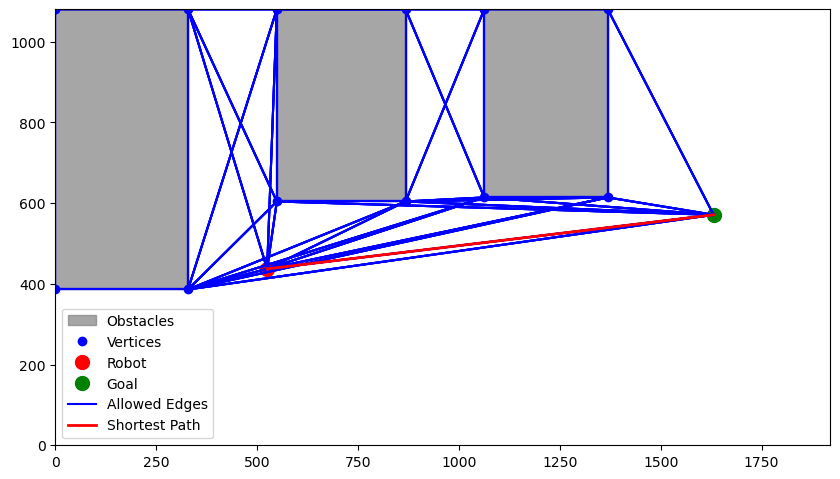

In [12]:
# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal()
robot_centroid, robot_direction = vision.vision_robot()

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot()

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

1 rotation
Kalman:  28.0 23.0 -0.020830320036217084 0.0 0.0
[-0.02083032] [0.11614163] [0.13697195]
[(88, 30)]
2 rotation
Kalman:  28.00976689448713 23.00002542031071 -0.0055845197069609425 0.7260011914989118 -0.7920012998135352
[-0.00558452] [0.11615995] [0.12174447]
[(88, 30)]
3 rotation
Kalman:  28.00000031992979 23.000048305329575 0.053164243880552485 1.2946172395053073 -1.1846170277795678
[0.05316424] [0.11614083] [0.06297659]
[(88, 30)]
4 translation
Kalman:  28.010298983778014 23.000506177212795 0.06073830073981383 0.7327946900565094 -0.45294131687860484
trabslation: [(88, 30)]
Error: [60.39666499]
5 translation
Kalman:  28.22945564591544 23.01337564779297 0.08487547723554771 1.2996083568885557 0.8466310438321373
trabslation: [(88, 30)]
Error: [60.1774949]
6 translation
Kalman:  28.764810082696783 23.05917608050493 0.09049484576933801 1.5416541836415192 1.5470839334724298
trabslation: [(88, 30)]
Error: [59.64044568]
7 translation
Kalman:  29.459711117266696 23.12147386104078 0.0

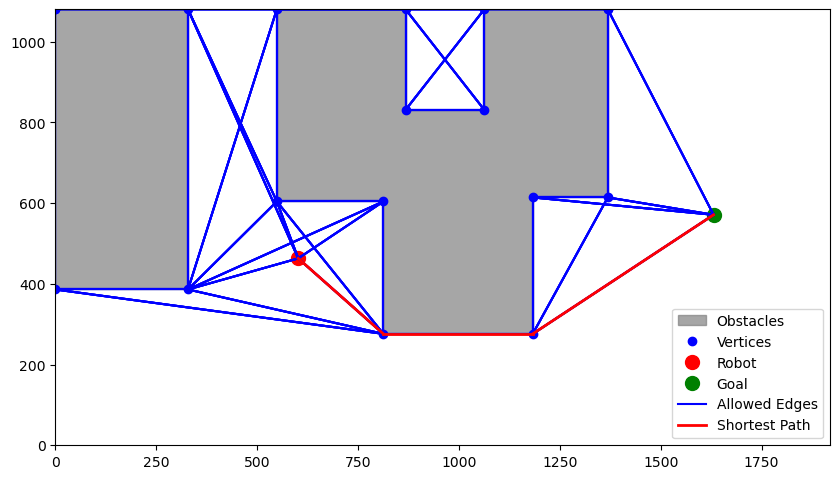

glob nav path : [(602.0, 463.0), (813.0, 276.0), (1183.0, 276.0), (1631.0, 571.0)]
camera measurements:  (32, 25) -0.14037498576433333
centroid camera:  (32, 25)
camera fin: [(43, 14), (63, 14), (88, 30)]
28 rotation
Kalman:  32.000000130366324 25.000006261424396 -0.14010653114454963 -1.5179726744674074 -1.478743738388916
[-0.14010653] [-0.78539845] [-0.64529192]
[(43, 14), (63, 14), (88, 30)]
29 rotation
Kalman:  31.470061477317312 25.07469996047449 -0.1555335219623579 -1.6584255635414682 -0.30141291758487543
[-0.15553352] [-0.76526172] [-0.6097282]
[(43, 14), (63, 14), (88, 30)]
30 rotation
Kalman:  31.196258833464057 25.11633743046344 -0.2120153453354165 -1.652132985394672 0.8016331067487856
[-0.21201535] [-0.75541582] [-0.54340047]
[(43, 14), (63, 14), (88, 30)]
31 rotation
Kalman:  31.081122851625256 25.14141989990117 -0.2929008092686238 -1.6847316725914405 1.2918910357072877
[-0.29290081] [-0.75169682] [-0.45879602]
[(43, 14), (63, 14), (88, 30)]
32 rotation
Kalman:  31.025718360

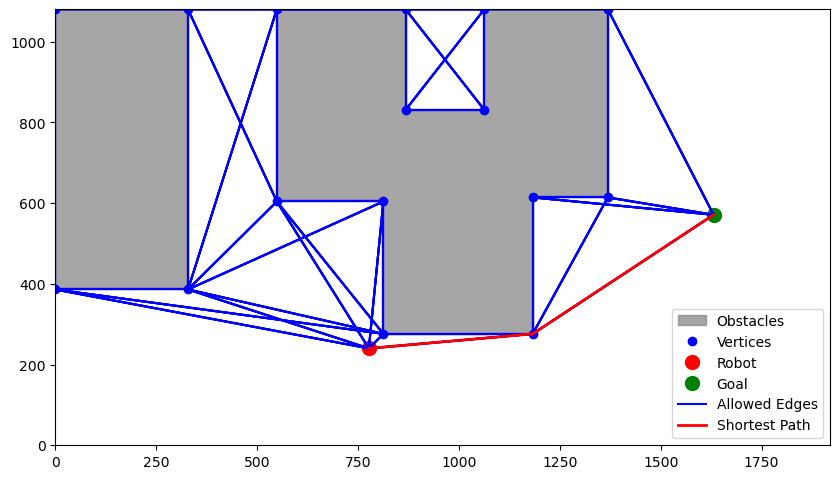

glob nav path : [(777.0, 240.0), (1183.0, 276.0), (1631.0, 571.0)]
camera measurements:  (42, 12) -0.8633647972289906
centroid camera:  (42, 12)
camera fin: [(63, 14), (88, 30)]
60 rotation
Kalman:  42.000220519956216 11.9999021544439 -0.8623564026014663 1.0506078217576238 1.3821892311180535
[-0.8623564] [0.09495731] [0.95731372]
[(63, 14), (88, 30)]
61 rotation
Kalman:  42.255521636210794 11.701744633064255 -0.8547855106628099 1.1717063209045115 -0.18808147377851325
[-0.85478551] [0.11033881] [0.96512432]
[(63, 14), (88, 30)]
62 rotation
Kalman:  42.353233829609586 11.58837937009181 -0.8000950668183671 1.4320073360251682 -0.9193386312210708
[-0.80009507] [0.11627691] [0.91637198]
[(63, 14), (88, 30)]
63 rotation
Kalman:  42.40257986953011 11.537944234222065 -0.7240908535737535 1.4986831075891907 -1.268784645431926
[-0.72409085] [0.11896778] [0.84305863]
[(63, 14), (88, 30)]
64 rotation
Kalman:  42.43373375188023 11.51042716453807 -0.638920502860123 1.5921954510657665 -1.40240435736170

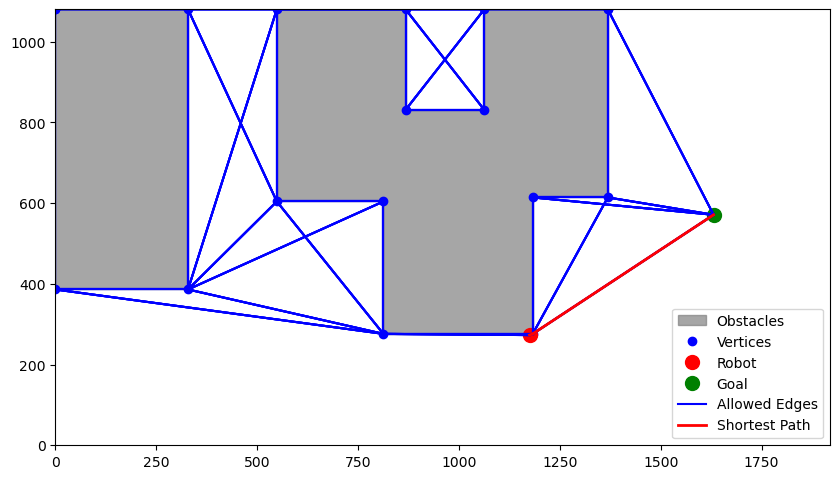

glob nav path : [(1175.0, 273.0), (1183.0, 276.0), (1631.0, 571.0)]
camera measurements:  (63, 14) 0.03881544608146369
centroid camera:  (63, 14)
camera fin: [(88, 30)]
101 rotation
Kalman:  63.00020202101223 14.000033564074783 0.03919563658445581 0.9530638114197942 0.8630234633216611
[0.03919564] [0.56931591] [0.53012027]
[(88, 30)]
102 rotation
Kalman:  63.29225670569888 14.011420189143399 0.056234621206749845 1.1022881865884062 -0.3627533263176186
[0.05623462] [0.57433953] [0.51810491]
[(88, 30)]
103 rotation
Kalman:  63.397168197045126 14.016948216972613 0.11361544273982141 1.3715556231110682 -1.0544492793855895
[0.11361544] [0.57612405] [0.46250861]
[(88, 30)]
104 rotation
Kalman:  63.457801462499084 14.023670491818898 0.19217484032843463 1.5775317358031873 -1.2864475259403731
[0.19217484] [0.57705952] [0.38488468]
[(88, 30)]
105 rotation
Kalman:  63.51027232902829 14.033997258598461 0.27855253001510843 1.6223166540217775 -1.375163447915202
[0.27855253] [0.57774267] [0.29919014]
[

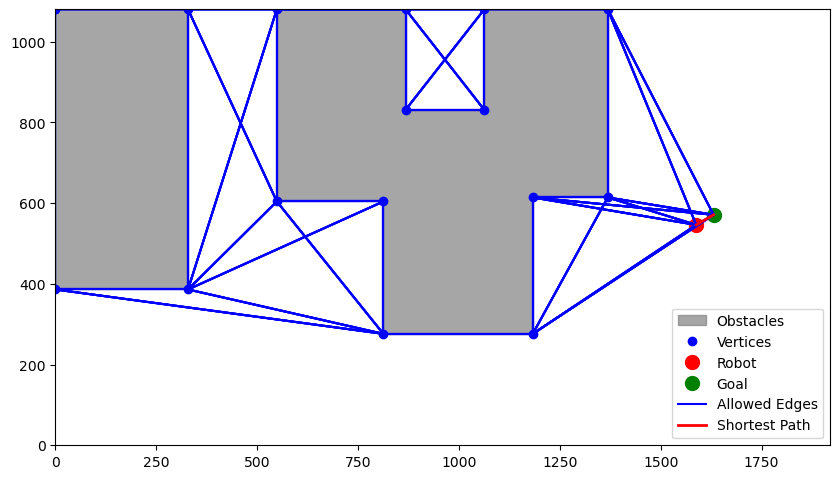

glob nav path : [(1588.0, 546.0), (1631.0, 571.0)]
camera measurements:  (85, 29) 0.5467888408892474
centroid camera:  (85, 29)
camera fin: [(88, 30)]
148 rotation
Kalman:  85.00028856995576 29.000248832086918 0.5474907645784746 1.2783520124579768 1.3757641688705557
[0.54749076] [0.32170476] [-0.22578601]
[(88, 30)]
149 rotation
Kalman:  85.4177307737006 29.25479706912308 0.5382438551493599 0.6008751647148848 1.3044946903839982
[0.53824386] [0.28095126] [-0.2572926]
[(88, 30)]
150 rotation
Kalman:  85.60413432080979 29.36909386985702 0.4885238187586935 -1.1598725161764678 1.4821638229746938
[0.48852382] [0.25748577] [-0.23103805]
[(88, 30)]
151 rotation
Kalman:  85.63057482432455 29.38283790455312 0.4047944120438122 -1.496661580702912 1.5178567856928815
[0.40479441] [0.25480743] [-0.14998699]
[(88, 30)]
152 rotation
Kalman:  85.64052111976977 29.38744599966646 0.3132351975356002 -1.5574340158548972 1.633512078184269
[0.3132352] [0.25400657] [-0.05922863]
[(88, 30)]
153 translation
Kalm

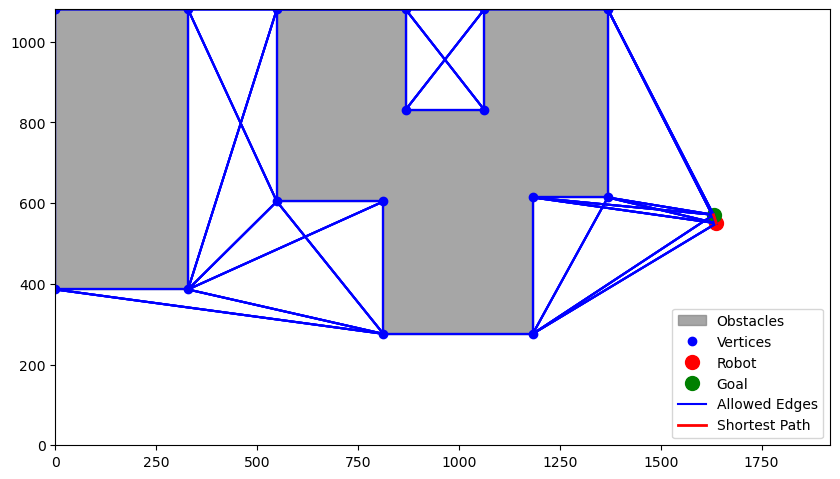

glob nav path : [(1638.0, 550.0), (1631.0, 571.0)]
camera measurements:  (88, 29) 0.21501488174750655
centroid camera:  (88, 29)
camera fin: []
159 rotation
je suis au goal


In [13]:
#ROBOT CONTROL AND LOCALISATION

# state variables
global_state = 'rotation'

#speed_correction = 12.5 #calibration cst for rotation counterclockwise
speed_correction = 14 #calibration cst for rotation counterclockwise
#speed_correction = 0.75 #0.65 #calibration cst for translation

intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])

#intermediate_goals = [(0, 10), (-10, 10), (-10, 0), (0,0)]
#intermediate_goals = [(56, 34), (66, 34), (87, 26)]
#robot = [(34.0,28.0)]
#robot_orientation = 1.6
robot_speed = [0.0,0.0]

Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)

#robot_speed = [30, -30] #robot speed for rotation (counterclockwise)
#robot_speed = [-30, 30] #robot speed for rotation (clockwise)
#robot_speed = [50, 50] #robot speed for translation
#await move_robot(robot_speed[0], robot_speed[1])

old_time = 0.0
printkal = True
iter = 0
while(True):
    iter = iter + 1
    print(iter, global_state)

    if intermediate_goals == []:
        await stop_robot()
        print("je suis au goal")
        break
    
    # get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    # test if local (with proximity)
        
    if(detected):
        await stop_robot()
        global_state = 'local_avoidance'

    
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    #print(speed_right_meas, speed_left_meas, "  ", robot_speed[0], robot_speed[1])
    speed_right_meas = speed_right_meas * speed_correction
    speed_left_meas = speed_left_meas * speed_correction
    
    #speed_right_meas = robot_speed[0] * speed_correction
    #speed_left_meas = robot_speed[1] * speed_correction

    Kfilter.measurement_wheels(speed_right_meas / 18.1818, speed_left_meas / 18.1818)

    if iter == 0:                   # first time
        old_time = time.time()
    dt = time.time() - old_time     # get time difference for Kalman
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    #print(dt, time.time(), old_time)
    if printkal:
        print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])
        #printkal = False
    #print("Kalman Sigma: ", Kfilter.Sigma)
    #print("Kalman y: ", Kfilter.y)
    
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    if global_state == 'rotation':
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print(Kfilter.Mu[2], np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), angle)
        print(intermediate_goals)
        if(abs(angle) < 0.1):
            await stop_robot()
            global_state = 'translation'
            continue

        if(angle > 0):
            robot_speed = [30, -30]         # counterclockwise
            speed_correction = 1.0 #32 #14
        else:
            robot_speed = [-30, 30]         # clockwise
            speed_correction = 1.0 #12.5

    elif global_state == 'translation':
        
        print("trabslation:", intermediate_goals)
        print("Error:", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        #if(np.sqrt(Kfilter.Mu[0][0]**2 + Kfilter.Mu[1][0]**2) > 10.0):     #translation condition
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 0.8:
            print("je m'arrete")
            await stop_robot()
            #intermediate_goals.pop(0)
            global_state = 'camera'
            continue
            
        
        
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        P_control_translation = 0 / (math.pi / 4.0)
        robot_speed = [50 + int(P_control_translation*angle), 50 - int(P_control_translation*angle)]
        speed_correction = 0.75

        
        if abs(angle) > math.pi / 2.0:
            await stop_robot()
            global_state = 'camera'
            continue
        
        
    elif global_state == 'camera':
        robot_centroid = [0,0]
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            robot_centroid, robot_direction = vision.vision_robot()
            
        merge_need = True
        visualize = True
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))
        print("glob nav path :", shortest_path)
        
        
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO) #changer pixel
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        #print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])
        print("camera measurements: ", robot_centroid, robot_angle)
        printkal = True
        
        intermediate_goals = shortest_path
        intermediate_goals.pop(0)
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 0.8:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("camera fin:", shortest_path)
        
        global_state = 'rotation'
        continue
        
        
        
    elif global_state == 'local_avoidance':
        print("local")
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        if is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
        
        print("OBject:", Object)
        print("avant append:", obstacles)
        obstacles.append(Object)
        print("après append:", obstacles)
        prox_sensors_bool = True
        
        while prox_sensors_bool:
            await move_robot(-50, -50)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * 20) #cst.THRESHOLD_PROX_SENSOR
            await client.sleep(0.4)
        
        global_state = "camera"
        continue

        
        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [15]:
await stop_robot()